# Random Grid Map Generator (10 maps: reward × risk)

This notebook **generates gridworld map CSVs from scratch** (no template file needed).

**Schema (matches your task):**
- `x` (int), `y` (int)
- `mine_type` (string or blank): `"Gold Mine A"`, `"Gold Mine B"`, `"Gold Mine C"`
- `alien_id` (int or blank): alien index placed at that tile

**Constraints**
- **No mines or aliens** in the **center 3×3** region.
- **Minimum aliens = 2**.
- **High-reward areas** are generated **locally around each alien** (one “zone” per alien).

This notebook creates **10 maps** spanning reward and risk:
- Reward: `high`, `middle`, `low`, plus one extra `very_low` (to reach 10 total)
- Risk: `high`, `middle`, `low` (mapped to number of aliens)

Outputs are saved as:
- `high_reward_high_risk.csv`
- `middle_reward_high_risk.csv`
- ...

In [1]:
import os
import math
import random
import re
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Global settings
# ----------------------------
GRID_W = 13
GRID_H = 13

# Center 3x3: for a 13x13 grid, that's x,y in {5,6,7}
FORBIDDEN_RADIUS = 1  # radius 1 around center -> 3x3

# Reproducibility
GLOBAL_SEED = 12345

# Output folder (same folder as this notebook)
OUT_DIR = "."

# How many unique randomized maps to generate PER reward×risk construct.
# Files are saved as: <reward>_reward_<risk>_risk_01.csv, _02.csv, ...
VARIANTS_PER_SPEC = 1

In [2]:
# ----------------------------
# Helpers
# ----------------------------
MINE_TYPES = ["Gold Mine A", "Gold Mine B", "Gold Mine C"]

def forbidden_center_coords(w: int, h: int, radius: int = 1) -> set:
    """Return coordinates in the center (2*radius+1) square."""
    cx = (w - 1) // 2
    cy = (h - 1) // 2
    banned = set()
    for x in range(cx - radius, cx + radius + 1):
        for y in range(cy - radius, cy + radius + 1):
            if 0 <= x < w and 0 <= y < h:
                banned.add((x, y))
    return banned

def chebyshev(a: Tuple[int, int], b: Tuple[int, int]) -> int:
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

def weighted_choice(rng: random.Random, items: List[str], weights: List[float]) -> str:
    # Safe handling of weights that don't sum to 1
    tot = float(sum(weights))
    if tot <= 0:
        return rng.choice(items)
    r = rng.random() * tot
    c = 0.0
    for it, w in zip(items, weights):
        c += float(w)
        if r <= c:
            return it
    return items[-1]

def sample_points_with_min_distance(rng: random.Random,
                                   candidates: List[Tuple[int,int]],
                                   k: int,
                                   min_dist: int,
                                   max_tries: int = 5000) -> List[Tuple[int,int]]:
    """Rejection-sample k points from candidates with min Chebyshev distance."""
    chosen: List[Tuple[int,int]] = []
    tries = 0
    if k <= 0:
        return chosen
    cand = candidates[:]
    rng.shuffle(cand)
    while tries < max_tries and len(chosen) < k:
        if not cand:
            # reshuffle and retry
            cand = candidates[:]
            rng.shuffle(cand)
        p = cand.pop()
        if all(chebyshev(p, q) >= min_dist for q in chosen):
            chosen.append(p)
        tries += 1
    if len(chosen) < k:
        raise RuntimeError(f"Could not place {k} aliens with min_dist={min_dist}. Try lowering min_dist or k.")
    return chosen

def neighbors_within_radius(x: int, y: int, w: int, h: int, radius: int) -> List[Tuple[int,int]]:
    pts = []
    for xx in range(x - radius, x + radius + 1):
        for yy in range(y - radius, y + radius + 1):
            if 0 <= xx < w and 0 <= yy < h and not (xx == x and yy == y):
                pts.append((xx, yy))
    return pts


def next_available_index(out_dir: str, base_stem: str) -> int:
    """Return next index k for files like f"{base_stem}_{k:02d}.csv" in out_dir."""
    try:
        files = os.listdir(out_dir)
    except FileNotFoundError:
        return 1

    pat = re.compile(rf"^{re.escape(base_stem)}_(\d+)\.csv$")
    used = []
    for fn in files:
        m = pat.match(fn)
        if m:
            try:
                used.append(int(m.group(1)))
            except ValueError:
                pass
    return (max(used) + 1) if used else 1


In [3]:
@dataclass
class RewardConfig:
    label: str                      # 'high' | 'middle' | 'low' | 'very_low'
    total_mines_target: int         # overall mine count target (zones + background)
    background_mix: Tuple[float,float,float]  # (A,B,C) for mines NOT in alien zones
    zone_radius: int                # local radius around alien to consider for zone tiles
    zone_fraction: float            # fraction of mines allocated to alien zones (approx)

@dataclass
class RiskConfig:
    label: str                      # 'high' | 'middle' | 'low'
    num_aliens: int                 # minimum 2 enforced elsewhere
    min_alien_dist: int             # keep aliens separated (Chebyshev distance)

REWARD_CONFIGS: Dict[str, RewardConfig] = {
    "high": RewardConfig(
        label="high",
        total_mines_target=60,
        background_mix=(0.20, 0.35, 0.45),
        zone_radius=2,
        zone_fraction=0.55,
    ),
    "middle": RewardConfig(
        label="middle",
        total_mines_target=40,
        background_mix=(0.40, 0.40, 0.20),
        zone_radius=2,
        zone_fraction=0.50,
    ),
    "low": RewardConfig(
        label="low",
        total_mines_target=25,
        background_mix=(0.65, 0.30, 0.05),
        zone_radius=1,
        zone_fraction=0.45,
    ),
    # Extra level to reach 10 total maps
    "very_low": RewardConfig(
        label="very_low",
        total_mines_target=15,
        background_mix=(0.80, 0.20, 0.00),
        zone_radius=1,
        zone_fraction=0.40,
    ),
}

RISK_CONFIGS: Dict[str, RiskConfig] = {
    "low": RiskConfig(label="low", num_aliens=2, min_alien_dist=4),
    "middle": RiskConfig(label="middle", num_aliens=4, min_alien_dist=3),
    "high": RiskConfig(label="high", num_aliens=6, min_alien_dist=3),
}

In [4]:
def generate_map_df(
    reward: str,
    risk: str,
    w: int = GRID_W,
    h: int = GRID_H,
    seed: int = 0,
) -> pd.DataFrame:
    """Generate one map DataFrame with columns x,y,mine_type,alien_id."""
    if reward not in REWARD_CONFIGS:
        raise ValueError(f"Unknown reward level: {reward}")
    if risk not in RISK_CONFIGS:
        raise ValueError(f"Unknown risk level: {risk}")

    rconf = REWARD_CONFIGS[reward]
    kconf = RISK_CONFIGS[risk]

    # Enforce minimum aliens = 2
    n_aliens = max(2, int(kconf.num_aliens))

    rng = random.Random(seed)

    banned = forbidden_center_coords(w, h, radius=FORBIDDEN_RADIUS)

    all_coords = [(x, y) for x in range(w) for y in range(h)]
    allowed_coords = [p for p in all_coords if p not in banned]

    # Place aliens
    alien_coords = sample_points_with_min_distance(
        rng=rng,
        candidates=allowed_coords,
        k=n_aliens,
        min_dist=int(kconf.min_alien_dist),
    )

    occupied_aliens = set(alien_coords)
    occupied_mines = set()

    # Decide how many mines go into alien zones (total across all aliens)
    total_target = int(rconf.total_mines_target)
    zone_total = int(round(total_target * float(rconf.zone_fraction)))

    # Each alien must have a local zone ("high reward area")
    min_zone_per_alien = 2
    zone_total = max(zone_total, n_aliens * min_zone_per_alien)

    # If zone_total is too big (not enough space), cap it safely later.
    # Split zone mines across aliens (evenly, remainder distributed)
    base = zone_total // n_aliens
    rem = zone_total % n_aliens
    zone_counts = [base + (1 if i < rem else 0) for i in range(n_aliens)]

    # Zone mine-type preference (heavier toward C)
    # NOTE: we force at least one C per alien-zone when possible.
    if reward == "high":
        zone_mix = (0.00, 0.30, 0.70)   # A,B,C
    elif reward == "middle":
        zone_mix = (0.00, 0.55, 0.45)
    elif reward == "low":
        zone_mix = (0.00, 0.75, 0.25)
    else:  # very_low
        zone_mix = (0.00, 0.85, 0.15)

    zone_tiles_by_alien: List[List[Tuple[int,int]]] = []
    for (ax, ay) in alien_coords:
        cand = neighbors_within_radius(ax, ay, w, h, radius=int(rconf.zone_radius))
        # Remove banned + alien tiles
        cand = [p for p in cand if p not in banned and p not in occupied_aliens]
        zone_tiles_by_alien.append(cand)

    # Place zone mines
    mine_type_at: Dict[Tuple[int,int], str] = {}

    for i, (ax, ay) in enumerate(alien_coords):
        # Candidate tiles for this alien's zone excluding already-occupied mines
        cand = [p for p in zone_tiles_by_alien[i] if p not in occupied_mines]
        rng.shuffle(cand)

        want = zone_counts[i]
        if want <= 0:
            continue
        if not cand:
            continue

        # Cap by available tiles
        want = min(want, len(cand))
        chosen = cand[:want]

        # Force at least one C in this zone if possible
        types = []
        for j in range(want):
            t = weighted_choice(rng, MINE_TYPES, list(zone_mix))
            types.append(t)
        if want >= 1:
            types[0] = "Gold Mine C"

        for p, t in zip(chosen, types):
            occupied_mines.add(p)
            mine_type_at[p] = t

    # Remaining mines placed randomly across the map
    remaining = max(0, total_target - len(occupied_mines))

    # Candidates for background mines (not banned, not aliens, not existing mines)
    bg_candidates = [p for p in allowed_coords if p not in occupied_aliens and p not in occupied_mines]
    rng.shuffle(bg_candidates)
    remaining = min(remaining, len(bg_candidates))
    bg_chosen = bg_candidates[:remaining]

    for p in bg_chosen:
        t = weighted_choice(rng, MINE_TYPES, list(rconf.background_mix))
        # If very_low has zero C in background_mix, this will never pick C (fine).
        mine_type_at[p] = t
        occupied_mines.add(p)

    # Build DataFrame (full grid)
    rows = []
    alien_id_at = {p: (idx + 1) for idx, p in enumerate(alien_coords)}
    for x in range(w):
        for y in range(h):
            rows.append({
                "x": x,
                "y": y,
                "mine_type": mine_type_at.get((x, y), np.nan),
                "alien_id": alien_id_at.get((x, y), np.nan),
            })
    return pd.DataFrame(rows)

In [5]:
def summarize_map(df: pd.DataFrame) -> Dict[str, int]:
    mines = df["mine_type"].dropna()
    aliens = df["alien_id"].dropna()
    return {
        "n_aliens": int(aliens.nunique()),
        "n_mines": int(mines.shape[0]),
        "n_A": int((mines == "Gold Mine A").sum()),
        "n_B": int((mines == "Gold Mine B").sum()),
        "n_C": int((mines == "Gold Mine C").sum()),
    }

def plot_map(df: pd.DataFrame, title: str, w: int = GRID_W, h: int = GRID_H):
    # Extract positions
    A = df[df["mine_type"] == "Gold Mine A"][["x","y"]].to_numpy()
    B = df[df["mine_type"] == "Gold Mine B"][["x","y"]].to_numpy()
    C = df[df["mine_type"] == "Gold Mine C"][["x","y"]].to_numpy()
    Ali = df[df["alien_id"].notna()][["x","y","alien_id"]].to_numpy()

    plt.figure(figsize=(5.5, 5.5))
    ax = plt.gca()

    if len(A): ax.scatter(A[:,0], A[:,1], marker="s", label="Mine A")
    if len(B): ax.scatter(B[:,0], B[:,1], marker="o", label="Mine B")
    if len(C): ax.scatter(C[:,0], C[:,1], marker="^", label="Mine C")
    if len(Ali): ax.scatter(Ali[:,0], Ali[:,1], marker="X", s=120, label="Alien")

    # Axes / grid
    ax.set_xlim(-0.5, w - 0.5)
    ax.set_ylim(-0.5, h - 0.5)
    ax.set_xticks(range(w))
    ax.set_yticks(range(h))
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()  # top-left (0,0) look like a grid-map

    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8)
    plt.show()

OUT_DIR=/Users/jianleguo/Documents/GitHub/Role_Speficifed_Collective_Foraging_Task/Util_ipynb
Generating 1 variant(s) per construct (saved with _01, _02, ...).

=== high_reward_high_risk_01.csv ===
reward_type=high | risk_type=high
{'n_aliens': 6, 'n_mines': 60, 'n_A': 8, 'n_B': 14, 'n_C': 38}


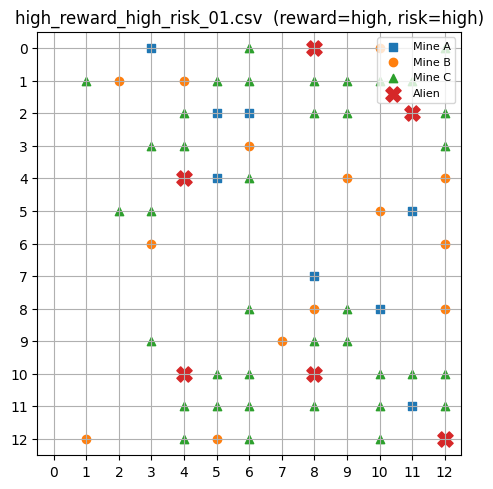


=== high_reward_middle_risk_01.csv ===
reward_type=high | risk_type=middle
{'n_aliens': 4, 'n_mines': 60, 'n_A': 7, 'n_B': 22, 'n_C': 31}


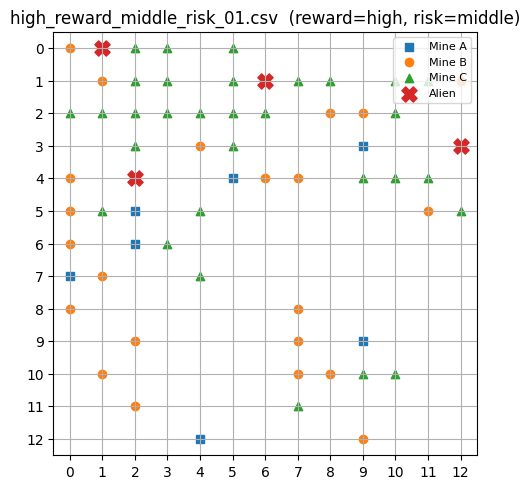


=== high_reward_low_risk_01.csv ===
reward_type=high | risk_type=low
{'n_aliens': 2, 'n_mines': 60, 'n_A': 6, 'n_B': 21, 'n_C': 33}


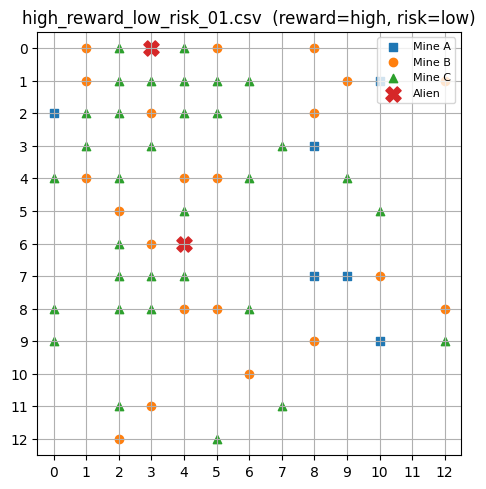


=== middle_reward_high_risk_01.csv ===
reward_type=middle | risk_type=high
{'n_aliens': 6, 'n_mines': 40, 'n_A': 8, 'n_B': 18, 'n_C': 14}


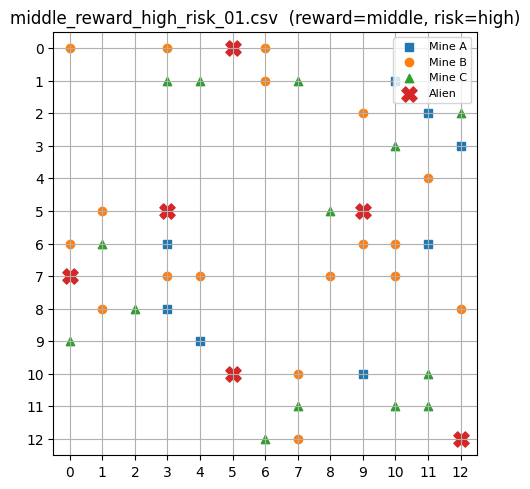


=== middle_reward_middle_risk_01.csv ===
reward_type=middle | risk_type=middle
{'n_aliens': 4, 'n_mines': 40, 'n_A': 9, 'n_B': 15, 'n_C': 16}


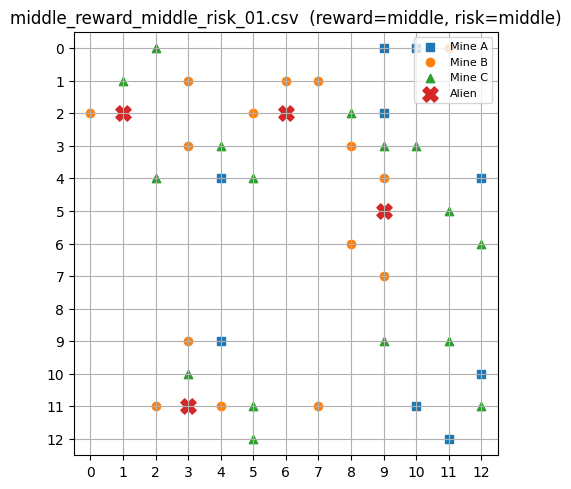


=== middle_reward_middle_risk_02.csv ===
reward_type=middle | risk_type=middle
{'n_aliens': 4, 'n_mines': 40, 'n_A': 6, 'n_B': 20, 'n_C': 14}


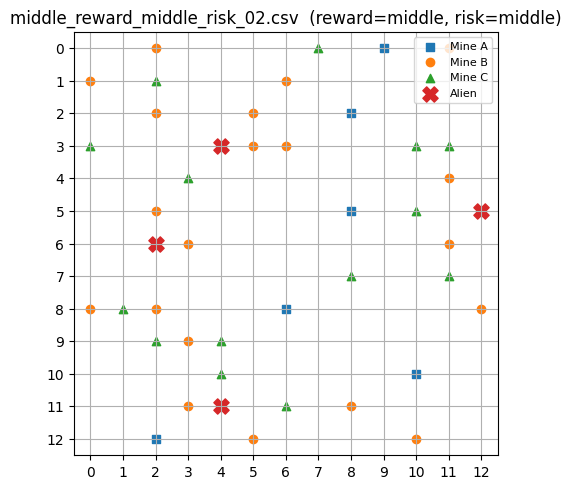


=== middle_reward_low_risk_01.csv ===
reward_type=middle | risk_type=low
{'n_aliens': 2, 'n_mines': 40, 'n_A': 7, 'n_B': 17, 'n_C': 16}


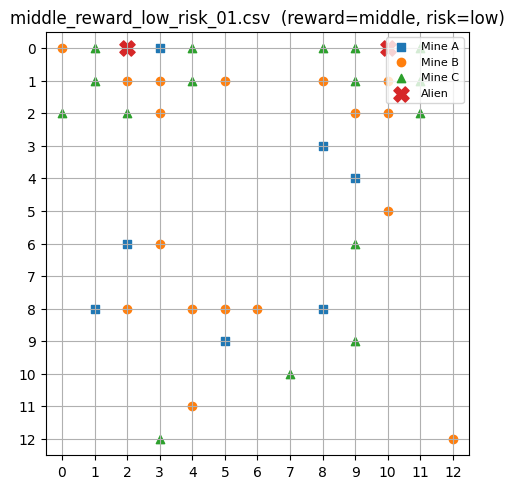


=== low_reward_high_risk_01.csv ===
reward_type=low | risk_type=high
{'n_aliens': 6, 'n_mines': 25, 'n_A': 9, 'n_B': 7, 'n_C': 9}


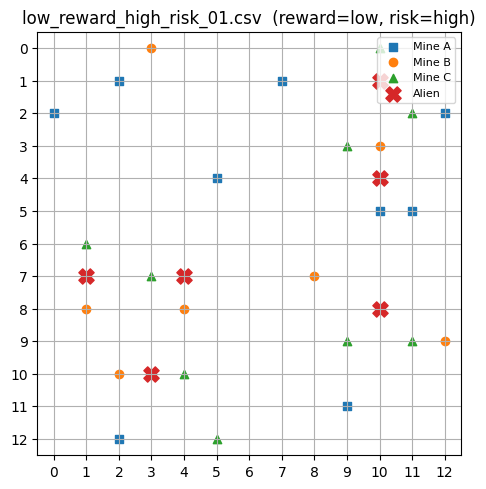


=== low_reward_middle_risk_01.csv ===
reward_type=low | risk_type=middle
{'n_aliens': 4, 'n_mines': 25, 'n_A': 8, 'n_B': 9, 'n_C': 8}


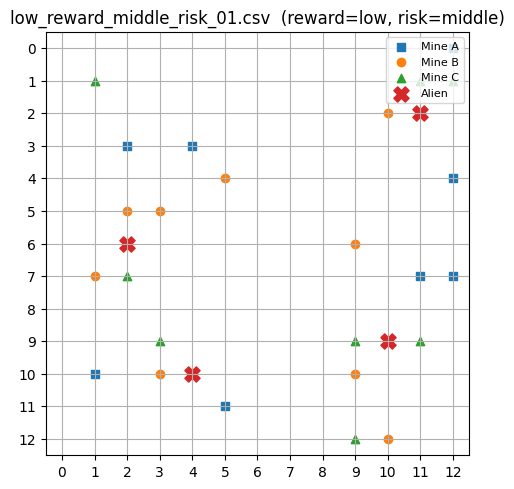


=== low_reward_low_risk_01.csv ===
reward_type=low | risk_type=low
{'n_aliens': 2, 'n_mines': 25, 'n_A': 10, 'n_B': 12, 'n_C': 3}


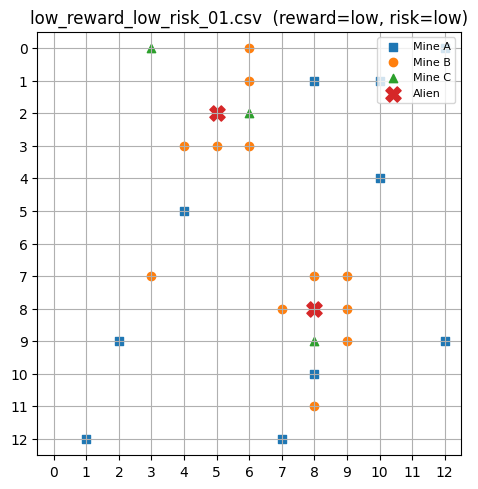


=== very_low_reward_low_risk_01.csv ===
reward_type=very_low | risk_type=low
{'n_aliens': 2, 'n_mines': 15, 'n_A': 8, 'n_B': 4, 'n_C': 3}


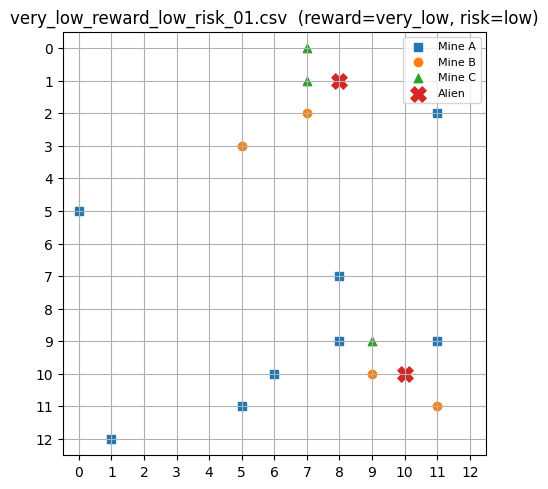


Done. Wrote:
 - ./high_reward_high_risk_01.csv
 - ./high_reward_middle_risk_01.csv
 - ./high_reward_low_risk_01.csv
 - ./middle_reward_high_risk_01.csv
 - ./middle_reward_middle_risk_01.csv
 - ./middle_reward_middle_risk_02.csv
 - ./middle_reward_low_risk_01.csv
 - ./low_reward_high_risk_01.csv
 - ./low_reward_middle_risk_01.csv
 - ./low_reward_low_risk_01.csv
 - ./very_low_reward_low_risk_01.csv


In [6]:
# ----------------------------
# Generate the 10 map constructs (reward × risk) in order
# ----------------------------

# 9 combos (high/middle/low × high/middle/low) + 1 extra very_low_reward_low_risk
MAP_SPECS = [
    ("high", "high"),
    ("high", "middle"),
    ("high", "low"),
    ("middle", "high"),
    ("middle", "middle"),
    ("middle", "middle"),
    ("middle", "low"),
    ("low", "high"),
    ("low", "middle"),
    ("low", "low"),
    ("very_low", "low"),
]

os.makedirs(OUT_DIR, exist_ok=True)

print(f"OUT_DIR={os.path.abspath(OUT_DIR)}")
print(f"Generating {VARIANTS_PER_SPEC} variant(s) per construct (saved with _01, _02, ...).")

all_outputs = []

for spec_idx, (reward, risk) in enumerate(MAP_SPECS):
    base_stem = f"{reward}_reward_{risk}_risk"
    start_k = next_available_index(OUT_DIR, base_stem)

    for v in range(VARIANTS_PER_SPEC):
        k = start_k + v
        fname = f"{base_stem}_{k:02d}.csv"
        out_path = os.path.join(OUT_DIR, fname)

        # Different seed per map (reproducible, distinct per construct and variant)
        seed = GLOBAL_SEED + 1000 * spec_idx + 97 * k + 17

        df_map = generate_map_df(reward=reward, risk=risk, seed=seed)

        # Sanity: ensure nothing spawned in center 3x3
        banned = forbidden_center_coords(GRID_W, GRID_H, radius=FORBIDDEN_RADIUS)
        bad_mines = df_map[df_map["mine_type"].notna()].apply(lambda r: (int(r.x), int(r.y)) in banned, axis=1).any()
        bad_aliens = df_map[df_map["alien_id"].notna()].apply(lambda r: (int(r.x), int(r.y)) in banned, axis=1).any()
        assert not bad_mines and not bad_aliens, "Forbidden center 3x3 violated."

        df_map.to_csv(out_path, index=False)
        all_outputs.append(out_path)

        stats = summarize_map(df_map)
        print(f"\n=== {fname} ===")
        print(f"reward_type={reward} | risk_type={risk}")
        print(stats)

        # Display maps in sequence (one plot per generated CSV)
        plot_map(df_map, title=f"{fname}  (reward={reward}, risk={risk})")

print("\nDone. Wrote:")
for p in all_outputs:
    print(" -", p)
